In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import itertools
from itertools import permutations
from tensorflow import keras
from tensorflow.keras import layers

# Top k-Ranking 

class MAB:
    def __init__(self, arms_len, max_k, nnet, mode):
        self.arms_len = arms_len
        self.max_k = max_k
        self.nnet = nnet
        self.mode = mode
        
        self.rewards = []
        self.arms_reward = np.zeros(self.arms_len)
        self.arms_expectation = .00001*np.random.random_sample((self.arms_len,)) # np.zeros(self.arms_len)
        self.arms_expectation_counts = np.zeros(self.arms_len)
        
    def choose_arms(self):
        if self.mode == 'rand':
            return np.random.permutation(self.arms_len)[0:self.max_k]
        elif self.mode == 'epsilon_greedy':
            if np.random.random_sample()<0.1:
                return np.random.permutation(self.arms_len)[0:self.max_k]
            else:
                arms_expectation_sorted_index = np.flip(np.argsort(self.arms_expectation))
                return arms_expectation_sorted_index[0:self.max_k]
        elif self.mode == 'max_expectation':
            arms_expectation_sorted_index = np.flip(np.argsort(self.arms_expectation))
            return arms_expectation_sorted_index[0:self.max_k]
        elif self.mode == 'optimal':
            if self.max_k == 1:
                return np.array([5])
            elif self.max_k == 2:
                return np.array([5, 6])
            elif self.max_k == 3:
                return np.array([4, 5, 6])
            elif self.max_k == 4:
                return np.array([4, 5, 6, 7])
        elif 'ucb' in self.mode:
            arms_std = np.zeros(self.arms_len)
            for i in range(self.arms_len):
                for j in range(len(self.rewards)):
                    if i in self.rewards[j][0]:
                        arms_std[i] = arms_std[i] + np.power(self.rewards[j][1] - self.arms_expectation[i], 2)
            
            arms_ucb = np.zeros(self.arms_len)
            for i in range(self.arms_len):
                if self.arms_expectation_counts[i]>0:
                    if self.mode == 'ucb':
                        arms_ucb[i] = self.arms_expectation[i] + arms_std[i]/self.arms_expectation_counts[i]
                    if self.mode == 'ucb2':
                        arms_ucb[i] = self.arms_expectation[i] + arms_std[i]*np.maximum(0, 30-self.arms_expectation_counts[i])
                else:
                    arms_ucb[i] = self.arms_expectation[i] + arms_std[i]
                
            arms_ucb_sorted_index = np.flip(np.argsort(arms_ucb))
            return arms_ucb_sorted_index[0:self.max_k]
    
    def set_reward(self, arms, reward):
        self.rewards.append((arms, reward))
        for arm in arms:
            arm = int(arm)
            self.arms_reward[arm] += reward
            self.arms_expectation_counts[arm] += 1
            self.arms_expectation[arm] = self.arms_reward[arm]/self.arms_expectation_counts[arm]

def get_convnet():
    # Model / data parameters
    num_classes = 10
    input_shape = (28, 28, 1)

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    # Make sure images have shape (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    print("x_train shape:", x_train.shape)
    print(x_train.shape[0], "train samples")
    print(x_test.shape[0], "test samples")


    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

    model.summary()
    
    batch_size = 128
    epochs = 15

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    
    return model

def test_model(MAB,reward_noise):

    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    # Make sure images have shape (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    regret = np.zeros(int(np.shape(x_train)[0]/1000))

    for i in range(int(np.shape(x_train)[0]/1000)):
        y_train[i] = 5

        arms = MAB.choose_arms()
        error = np.zeros(arms.shape[0])
        for j in range(arms.shape[0]):
            arm = arms[j]
            error[j] = np.absolute(arm - y_train[i])
        if MAB.max_k == 1:
            total_error = np.sum(error)
        elif MAB.max_k == 2:
            total_error = np.sum(error)-1
        elif MAB.max_k == 3:
            total_error = np.sum(error)-2
        elif MAB.max_k == 4:
            total_error = np.sum(error)-4
        total_error = np.maximum(total_error + abs(np.random.randn())*reward_noise, 0)
        reward = -total_error
        MAB.set_reward(arms, reward)
        if i>0:
            regret[i] = total_error + regret[i-1]
        else:
            regret[i] = total_error
    
    return regret


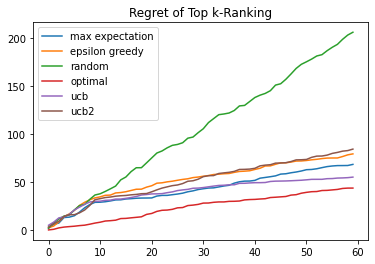

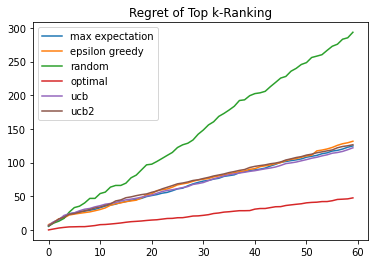

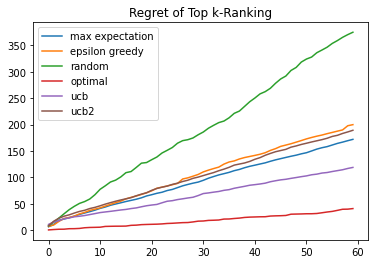

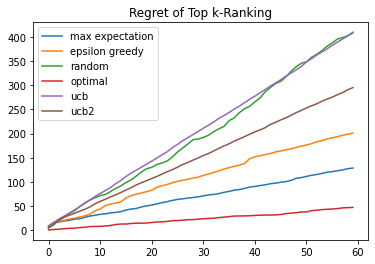

In [2]:
arms = 10
reward_noise = 1/1
for k in range(1,5):
    MAB_max_expectation = MAB(arms,k,None,'max_expectation')
    MAB_epsilon_greedy = MAB(arms,k,None,'epsilon_greedy')
    MAB_random = MAB(arms,k,None,'rand')
    MAB_optimal = MAB(arms,k,None,'optimal')
    MAB_ucb = MAB(arms,k,None,'ucb')
    MAB_ucb2 = MAB(arms,k,None,'ucb2')

    regret_max_expectation = test_model(MAB_max_expectation,reward_noise)
    regret_epsilon_greedy = test_model(MAB_epsilon_greedy,reward_noise)
    regret_random = test_model(MAB_random,reward_noise)
    regret_optimal = test_model(MAB_optimal,reward_noise)
    regret_ucb = test_model(MAB_ucb,reward_noise)
    regret_ucb2 = test_model(MAB_ucb2,reward_noise)

    plt.plot(range(len(regret_max_expectation)),regret_max_expectation,
             range(len(regret_epsilon_greedy)),regret_epsilon_greedy,
             range(len(regret_random)),regret_random,
             range(len(regret_optimal)),regret_optimal,
             range(len(regret_ucb)),regret_ucb,
             range(len(regret_ucb2)),regret_ucb2)
    plt.legend(['max expectation','epsilon greedy','random','optimal','ucb','ucb2'])
    plt.title('Regret of Top k-Ranking')
    plt.show()